# Проект "Бюро добрых дел"

Задача: Связь email-событий и платежей (воронка)

<h3>Заказчик: Благотворительный фонд помощи детям-отказникам и детям-сиротам “Бюро добрых дел“.</h3>
 <p>Фонд ищет форматы того, как обеспечить фонду пусть не очень большой, но стабильный поток денежных средств, для чего нужно провести углублённый анализ паттернов характера пожертвований и типов доноров.</p>
<p>После крупных медиа-событий — например, после того, как про “Бюро добрых дел” рассказали своим поклонникам актёры “Квартета И” — фонд получил много разовых пожертвований. Но цель фонда — ежедневная работа и ежедневная помощь нуждающимся в обучении и новой профессии, жилье, психологической помощи и т.д, и такие внезапные увеличения финансового потока сложно планировать заранее.</p>

<br> - Влияет ли на жертвователей получение email’ов от фонда с информацией о том, как тратятся средства и какие программы сейчас действуют и нуждаются в помощи?

<h3>Описание данных:</h3>
<br><ul><b>Содержимое таблицы df_clients:</b></ul>
<br><li>ID- id клиента</li>
<br><li>gender_male- пол (сгенерированый на основании имён, которые нам недоступны) - если 1 — мужчина, -1 — женщина, 0 — был пропуск</li>
<br><li>city- город плательщика (очень много пропусков)</li>
<br><li>email_action- последнее открытие письма (отдельная таблица с событиями открытия писем у заказчика запрошена, он может её предоставить eventually)</li>
<ul><b>Содержимое таблицы df_payments:</b></ul>
<br><li>client_id- бъющийся с первой таблицей id клиента</li>
<br><li>pay_datetime- дата платежа</li>
<br><li>pay_hour - час платежа (у части платежей час указан 0)</li>
<br><li>pay_sum- сумма платежа</li>
<br><li>recurrentis- был ли платёж по подписке</li>
<br><li>pay_method- по какому каналу поступили деньги</li>
<br><li>pay_purpose_cat- категория платежа (на основании основания платежа)</li>
<br><li>first_pay- первый платёж данного клиента</li>
<br><li>lt- количество дней, прошедшее с первого платежа данного клиента до даты данного платежа</li>

<ul><b>Задача проекта:</b></ul>
<br><li>- Связь email-событий и платежей (воронка?)</li>

In [85]:
import warnings
warnings.filterwarnings('ignore')

In [86]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from plotly import graph_objects as go

In [87]:
server_path = 'datasets/'   
local_path = '' 

files = ['df_clients.csv', 'df_email_reaction.csv', 'df_email_send.csv', 'df_payments.csv']

datasets = []

for file in files:
    try:
        datasets.append(pd.read_csv(server_path + file))
    except FileNotFoundError: 
        datasets.append(pd.read_csv(local_path + file))

temp_df_clients = datasets[0]
temp_df_email_reaction = datasets[1]
temp_df_email_send = datasets[2]
temp_df_payments = datasets[3]

def to_dt(df,col):
    df[col] = pd.to_datetime(df[col])

for df, col in [(temp_df_email_reaction,   "reaction_datetime"),
                (temp_df_email_send,       "send_datetime"),
                (temp_df_payments,         "pay_datetime")]:
    to_dt(df,col)

Таблица с клиентами:

In [88]:
temp_df_clients.head(2)

,ID,gender_male,city,email_action
0,AF575B85-917F-475D-8875-00055586E05B,0,NaN,NaN
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,0,NaN,NaN


In [89]:
temp_df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            3683 non-null   object
 1   gender_male   3683 non-null   int64 
 2   city          1015 non-null   object
 3   email_action  1835 non-null   object
dtypes: int64(1), object(3)
memory usage: 115.2+ KB


Таблица с информацией об открытии писем:

In [90]:
temp_df_email_reaction.head(2)

,ID,reaction_datetime
0,D3F7551A-8B93-4A92-966D-BE2E5D58131E,2022-05-03 21:09:38
1,D3F7551A-8B93-4A92-966D-BE2E5D58131E,2022-05-03 21:09:38


In [91]:
temp_df_email_reaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9224 entries, 0 to 9223
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 9224 non-null   object        
 1   reaction_datetime  9224 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 144.2+ KB


Таблица с информацией о рассылке писем:

In [92]:
temp_df_email_send.head(2)

,ID,send_datetime
0,D3F7551A-8B93-4A92-966D-BE2E5D58131E,2022-08-24 13:14:05
1,D3F7551A-8B93-4A92-966D-BE2E5D58131E,2022-08-12 19:05:00


In [93]:
temp_df_email_send.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9224 entries, 0 to 9223
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             9224 non-null   object        
 1   send_datetime  9224 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 144.2+ KB


Таблица с информацией о плательщиках:

In [94]:
temp_df_payments.head(2)

,client_id,pay_datetime,pay_date,pay_sum,recurrentis,pay_method,pay_purpose_cat,pay_hour,first_pay,lt
0,81662625-B780-41E6-ACEE-F8F5162E79A2,2015-07-19 20:25:16,2015-07-19,101.0,1,cards,general,20,2015-07-19,0
1,81662625-B780-41E6-ACEE-F8F5162E79A2,2015-07-19 20:10:11,2015-07-19,100.0,0,cards,general,20,2015-07-19,0


In [95]:
temp_df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14025 entries, 0 to 14024
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   client_id        14025 non-null  object        
 1   pay_datetime     14025 non-null  datetime64[ns]
 2   pay_date         14025 non-null  object        
 3   pay_sum          14025 non-null  float64       
 4   recurrentis      14025 non-null  int64         
 5   pay_method       14025 non-null  object        
 6   pay_purpose_cat  14025 non-null  object        
 7   pay_hour         14025 non-null  int64         
 8   first_pay        14025 non-null  object        
 9   lt               14025 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 1.1+ MB


Рассмотрим уникальные значения в столбцах: pay_method и pay_purpose_cat

In [96]:
temp_df_payments['pay_method'].unique()

array(['cards', 'sms', 'account', 'cash'], dtype=object)

In [97]:
temp_df_payments['pay_purpose_cat'].unique()

array(['general', 'return', 'telic'], dtype=object)

## Связь email-событий и платежей (воронка)

Подготовим данные и рассмотрим рассылки, реакции и платежи на одном графике для подбора рекламных компаний и дальнейшнего анализа.

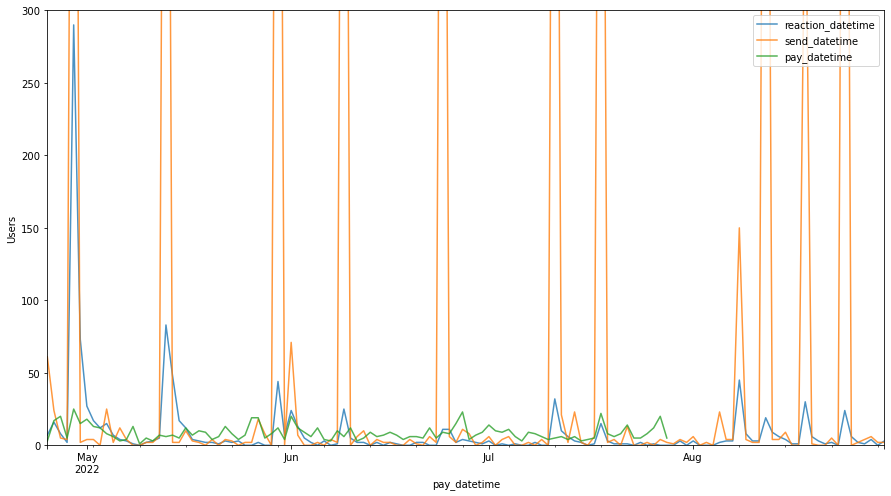

In [98]:
plot_freq = lambda df, col, ax, freq='1D':df.drop_duplicates()\
                                            .set_index(col)\
                                            .groupby([pd.Grouper(freq=freq)])\
                                            .agg({"ID":"count"})\
                                            .set_axis([col],axis=1)\
                                            .plot(ax=ax, alpha = .8)\
                                            .set(ylabel="Users")


temp_begin = temp_df_email_send.send_datetime.min()
temp_df_payments_cut = temp_df_payments.rename(columns={"client_id":"ID"})\
                                       .query("pay_datetime > @temp_begin")


fig, ax = plt.subplots(figsize=(15,8))
plot_freq(temp_df_email_reaction, "reaction_datetime", ax)
plot_freq(temp_df_email_send, "send_datetime", ax)
plot_freq(temp_df_payments_cut, "pay_datetime", ax)

plt.ylim((0,300));

Вывод: видно, что реакция на рассылку продолжается максимум 7 дней, а обычно вообще 2-3 дня. По данному графику подберем временные границы между рекламными кампаниями.

## Воронка для пользователей которые отреагировали на письма

Далее выделим плательщиков которые отреагировали на письма.

In [99]:
temp_df_payments_cut = temp_df_payments_cut[temp_df_payments_cut['recurrentis'] == 0]

In [100]:
temp_df_payments_cut_all = temp_df_payments_cut.groupby(pd.Grouper(key='pay_datetime', axis=0, 
                      freq='3D', sort=True))['ID'].count()

<AxesSubplot:xlabel='pay_datetime'>

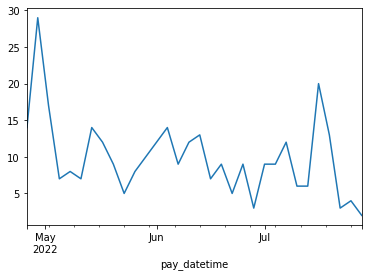

In [101]:
temp_df_payments_cut_all.plot()

In [102]:
temp_df_email_send = temp_df_email_send.groupby(pd.Grouper(key='send_datetime', axis=0, 
                      freq='1D', sort=True)).agg({'ID':'count'})
temp_df_email_send.head(30)

,ID
send_datetime,
2022-04-25,61
2022-04-26,24
2022-04-27,5
2022-04-28,4
2022-04-29,929
2022-04-30,2
2022-05-01,4
2022-05-02,4
2022-05-03,0


<AxesSubplot:xlabel='send_datetime'>

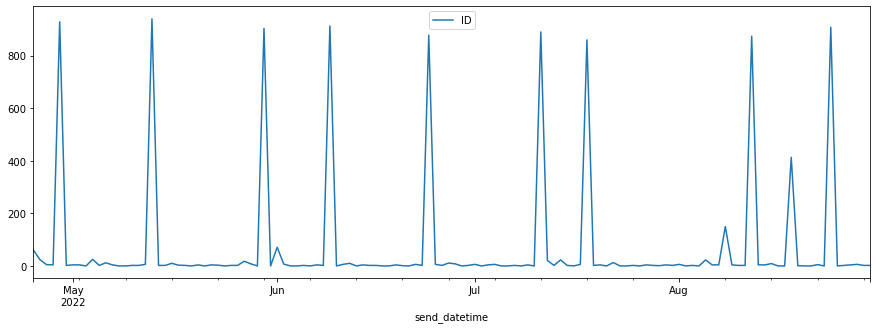

In [103]:
temp_df_email_send_pr = temp_df_email_send.reset_index()
temp_df_email_send.reset_index().plot(x='send_datetime', y='ID', figsize=(15,5))

In [104]:
temp_df_email_send = temp_df_email_send[temp_df_email_send['ID'] > 700].reset_index()
temp_df_email_send

,send_datetime,ID
0,2022-04-29,929
1,2022-05-13,940
2,2022-05-30,904
3,2022-06-09,913
4,2022-06-24,878
5,2022-07-11,890
6,2022-07-18,860
7,2022-08-12,874
8,2022-08-24,908


In [105]:
temp_df_email = temp_df_email_send['send_datetime'].astype(str).values
temp_df_email = [temp_df_email[i] for i in range(0, len(temp_df_email))]
temp_df_email

['2022-04-29',
 '2022-05-13',
 '2022-05-30',
 '2022-06-09',
 '2022-06-24',
 '2022-07-11',
 '2022-07-18',
 '2022-08-12',
 '2022-08-24']

In [106]:
temp_df_email_send['send_datetime'].astype(np.int64)//10**9

0    1651190400
1    1652400000
2    1653868800
3    1654732800
4    1656028800
5    1657497600
6    1658102400
7    1660262400
8    1661299200
Name: send_datetime, dtype: int64

In [107]:
temp_df_email_reaction = temp_df_email_reaction[temp_df_email_reaction['reaction_datetime'].between('2022-04-29', '2022-08-24', inclusive = True)]

In [108]:
temp_df_email_reaction['reaction_datetime_1'] = pd.cut(temp_df_email_reaction.reaction_datetime.astype(np.int64)//10**9,
                       bins=temp_df_email_send['send_datetime'].astype(np.int64)//10**9,
                       labels=temp_df_email[:-1])
temp_df_email_reaction

,ID,reaction_datetime,reaction_datetime_1
0,D3F7551A-8B93-4A92-966D-BE2E5D58131E,2022-05-03 21:09:38,2022-04-29
1,D3F7551A-8B93-4A92-966D-BE2E5D58131E,2022-05-03 21:09:38,2022-04-29
2,D3F7551A-8B93-4A92-966D-BE2E5D58131E,2022-05-03 21:09:38,2022-04-29
3,D3F7551A-8B93-4A92-966D-BE2E5D58131E,2022-05-03 21:09:38,2022-04-29
4,D3F7551A-8B93-4A92-966D-BE2E5D58131E,2022-05-03 21:09:38,2022-04-29
...,...,...,...
9210,A98BA2DA-F3B6-4EAA-9007-60C77BB9D8BA,2022-06-09 15:58:35,2022-06-09
9211,A98BA2DA-F3B6-4EAA-9007-60C77BB9D8BA,2022-06-09 15:58:35,2022-06-09
9212,A98BA2DA-F3B6-4EAA-9007-60C77BB9D8BA,2022-06-09 15:58:35,2022-06-09
9213,A98BA2DA-F3B6-4EAA-9007-60C77BB9D8BA,2022-06-09 15:58:35,2022-06-09


In [109]:
temp_df_email_reaction = temp_df_email_reaction.groupby('reaction_datetime_1')['ID'].nunique()
temp_df_email_reaction

reaction_datetime_1
2022-04-29    459
2022-05-13    182
2022-05-30     99
2022-06-09     43
2022-06-24     41
2022-07-11     54
2022-07-18     97
2022-08-12     82
Name: ID, dtype: int64

<AxesSubplot:xlabel='reaction_datetime_1'>

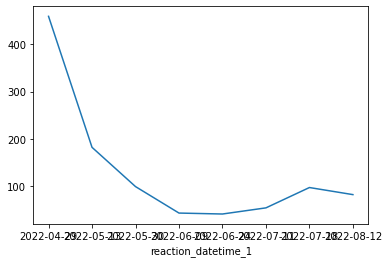

In [110]:
temp_df_email_reaction.plot()

In [111]:
temp_df_email_reaction = temp_df_email_reaction.to_frame().reset_index()
temp_df_email_reaction['reaction_datetime_1'] = pd.to_datetime(temp_df_email_reaction['reaction_datetime_1'])

In [112]:
df = temp_df_email_send.reset_index().merge(
    temp_df_email_reaction.reset_index(),
    left_on='send_datetime',
    right_on='reaction_datetime_1',
    how='inner')
df = df.drop(['reaction_datetime_1', 'index_x', 'index_y'], axis=1)
df = df.rename(columns={'send_datetime':'datetime', 'ID_x':'send_email', 'ID_y':'reaction_email'})
df

,datetime,send_email,reaction_email
0,2022-04-29,929,459
1,2022-05-13,940,182
2,2022-05-30,904,99
3,2022-06-09,913,43
4,2022-06-24,878,41
5,2022-07-11,890,54
6,2022-07-18,860,97
7,2022-08-12,874,82


In [113]:
df['CTR %'] = (df['reaction_email'] / df['send_email']) * 100
df

,datetime,send_email,reaction_email,CTR %
0,2022-04-29,929,459,49.407966
1,2022-05-13,940,182,19.361702
2,2022-05-30,904,99,10.951327
3,2022-06-09,913,43,4.709748
4,2022-06-24,878,41,4.669704
5,2022-07-11,890,54,6.067416
6,2022-07-18,860,97,11.279070
7,2022-08-12,874,82,9.382151


In [114]:
temp_df_payments_cut = temp_df_payments_cut[temp_df_payments_cut['pay_datetime'].between('2022-04-29', '2022-08-24', inclusive = True)]

In [115]:
temp_df_payments_cut['pay_datetime_1'] = pd.cut(temp_df_payments_cut.pay_datetime.astype(np.int64)//10**9,
                       bins=temp_df_email_send['send_datetime'].astype(np.int64)//10**9,
                       labels=temp_df_email[:-1])
temp_df_payments_cut

,ID,pay_datetime,pay_date,pay_sum,recurrentis,pay_method,pay_purpose_cat,pay_hour,first_pay,lt,pay_datetime_1
13250,BBA4E944-A48D-44B8-A0E6-E4FEB6486097,2022-04-29 15:55:39,2022-04-29,1000.0,0,cards,telic,15,2020-07-07,661,2022-04-29
13251,91478E1B-C882-4F24-A435-FC4930218C4A,2022-04-29 17:42:51,2022-04-29,100.0,0,cards,telic,17,2015-12-11,2331,2022-04-29
13253,81CD4BEF-443E-4D36-B34F-664E11182D65,2022-04-29 17:18:36,2022-04-29,300.0,0,cards,telic,17,2019-10-11,931,2022-04-29
13254,6D405455-BA95-43E9-9E03-47F2A922F7BA,2022-04-29 11:49:39,2022-04-29,10.0,0,cards,telic,11,2022-04-29,0,2022-04-29
13255,0AA8C81F-EBA3-4FDA-8B8F-28C1263D3E62,2022-04-29 22:46:05,2022-04-29,1000.0,0,cards,telic,22,2020-11-12,533,2022-04-29
...,...,...,...,...,...,...,...,...,...,...,...
13984,100B2146-E7A1-45CC-8E97-22CDE8FCA242,2022-07-25 14:47:49,2022-07-25,1000.0,0,cards,general,14,2021-12-25,212,2022-07-18
14011,CAD3BCE5-2860-4D2D-B198-CC47B8121244,2022-07-27 14:08:33,2022-07-27,500.0,0,cards,general,14,2020-04-28,820,2022-07-18
14017,568E4084-7312-4210-9E14-26D7D2080ED7,2022-07-27 16:14:04,2022-07-27,136.0,0,cards,general,16,2019-08-01,1091,2022-07-18
14020,D72C9BBA-0EAC-473D-BE6B-DE91EAF9BAB6,2022-07-28 09:39:02,2022-07-28,361.0,0,cards,telic,9,2021-06-05,418,2022-07-18


In [116]:
temp_df_payments_cut = temp_df_payments_cut.groupby('pay_datetime_1')['ID'].count()
temp_df_payments_cut

pay_datetime_1
2022-04-29    65
2022-05-13    51
2022-05-30    43
2022-06-09    46
2022-06-24    45
2022-07-11    19
2022-07-18    32
2022-08-12     0
Name: ID, dtype: int64

In [117]:
temp_df_payments_cut = temp_df_payments_cut.to_frame().reset_index()
temp_df_payments_cut['pay_datetime_1'] = pd.to_datetime(temp_df_payments_cut['pay_datetime_1'])

In [118]:
df = df.merge(temp_df_payments_cut, left_on='datetime', right_on='pay_datetime_1', how='outer')
df = df.rename(columns={'ID':'payments'})
df = df.drop('pay_datetime_1', axis=1)
df

,datetime,send_email,reaction_email,CTR %,payments
0,2022-04-29,929,459,49.407966,65
1,2022-05-13,940,182,19.361702,51
2,2022-05-30,904,99,10.951327,43
3,2022-06-09,913,43,4.709748,46
4,2022-06-24,878,41,4.669704,45
5,2022-07-11,890,54,6.067416,19
6,2022-07-18,860,97,11.279070,32
7,2022-08-12,874,82,9.382151,0


In [119]:
df['CR %'] = (df['payments'] / df['send_email']) * 100
df

,datetime,send_email,reaction_email,CTR %,payments,CR %
0,2022-04-29,929,459,49.407966,65,6.996771
1,2022-05-13,940,182,19.361702,51,5.425532
2,2022-05-30,904,99,10.951327,43,4.756637
3,2022-06-09,913,43,4.709748,46,5.038335
4,2022-06-24,878,41,4.669704,45,5.125285
5,2022-07-11,890,54,6.067416,19,2.134831
6,2022-07-18,860,97,11.279070,32,3.720930
7,2022-08-12,874,82,9.382151,0,0.000000


In [120]:
df = df[df['datetime'].between('2022-04-29', '2022-07-18', inclusive = True)]

<AxesSubplot:xlabel='datetime'>

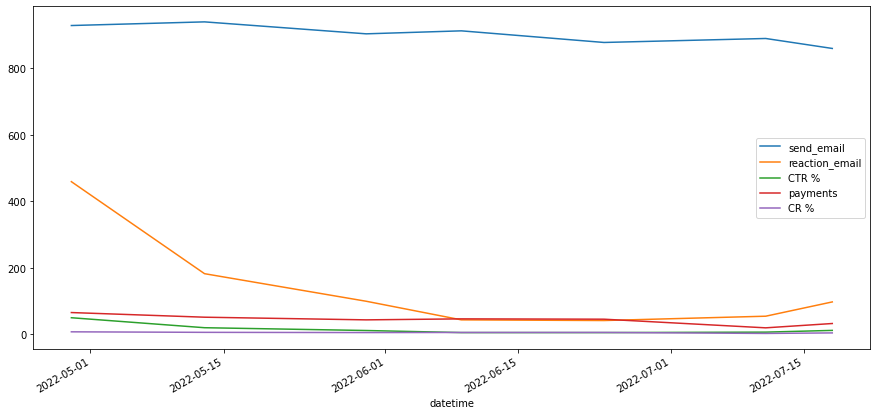

In [121]:
df.plot(x='datetime',
        y=['send_email', 'reaction_email', 'CTR %', 'payments', 'CR %'],
       figsize=(15,7))

Вывод: как видим из полученных данных, конверсия для плательщиков отреагирующих на письма уменьшается несмотря на то, что рассылка остается на том же уровне. Видно что конверсия летом проседает, особенно июль. Для более полного вывода хорошо бы посмотреть что будет дальше. Влияет на снижение сезон или это связано с внешне и внутреннеми экономическими причинами.